In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib as plt

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RFR

from sklearn.impute import SimpleImputer


import requests
import seaborn as sns
import warnings


warnings.filterwarnings("ignore")
%matplotlib inline
pd.options.display.max_rows = 200

In [562]:
nate = pd.read_excel('sales.xlsx', index = False)

In [563]:
nate.columns = ['store', 'dept', 'date', 'weekly_sales', 'holiday']

In [564]:
nate['year'] = nate.date.dt.year
nate['month'] = nate.date.dt.month

In [565]:
day_counts = nate.groupby(['store','year','month'], as_index = False)['weekly_sales'].count()

day_counts.columns = ['store', 'year','month', 'monthly_sales_count']

day_counts = day_counts

dept_counts = nate.groupby(['store', 'year'])['dept'].nunique().reset_index()

In [566]:
dept_counts= pd.DataFrame(dept_counts.copy())

dept_counts.columns = ['store', 'year','number_depts']

In [567]:
final_counts = pd.merge(day_counts, dept_counts, how = 'left', on = ['store', 'year'])

final_counts.columns = ['store', 'year','month', 'weekly_sales_reported', 'number_dept']

In [568]:
final_counts = pd.merge(nate, final_counts, how = 'left', on = ['store', 'month','year'])


In [569]:
total_sales = final_counts.groupby(['store','year', 'month'], as_index = False)['weekly_sales'].sum()

total_sales.columns = ['store', 'year', 'month', 'total_monthly_sales']

final_counts = pd.merge(final_counts, total_sales, how = 'left', on = ['store', 'year', 'month'])

In [570]:
final_counts = final_counts.sort_values(by = ['store','dept','year','month'], ascending = True)

## Setup for Monthly analysis

### Creates dataframe with imputed monthly sales reported for 1/2010 for each store 

In [15]:
imputed_monthly_sales = pd.DataFrame()

for i in day_counts.store.unique():

    tester_1 = day_counts[(day_counts.store == i)&(day_counts.month == 1)]
    tester_1.loc[-1] = np.zeros(len(tester_1.columns))  # adding a row
    tester_1.index = tester_1.index + 1 # shift index
    tester_1 = tester_1.sort_index()
    tester_1 = tester_1.replace(0, np.nan)

    tester_1 = tester_1.fillna(method = 'bfill')
    tester_1.year.loc[0] = (tester_1.year[0] - 1)
    tester_1.monthly_sales_count.loc[0] = 0

        ### Imputes missing 1/2010 values for all stores
    imp = SimpleImputer(missing_values = 0, strategy='mean')
    testing = imp.fit_transform(tester_1)
    test_df = pd.DataFrame(testing, columns = tester_1.columns)
    imputed_monthly_sales = imputed_monthly_sales.append(test_df)


### Creates dataframe to pull 1/2010 monthly sales values from for all stores

In [16]:
imputed_total_sales = pd.DataFrame()

for i in total_sales.store.unique():
    
    tester_1 = total_sales[(total_sales.store == i)&(total_sales.month == 1)]
    tester_1.loc[-1] = np.zeros(len(tester_1.columns))  # adding a row
    tester_1.index = tester_1.index + 1 # shift index
    tester_1 = tester_1.sort_index()
    tester_1 = tester_1.replace(0, np.nan)

    tester_1 = tester_1.fillna(method = 'bfill')
    tester_1.year.loc[0] = (tester_1.year[0] - 1)
    tester_1.total_monthly_sales.loc[0] = 0
        
    ### Imputes missing 1/2010 values for all stores
    imp = SimpleImputer(missing_values = 0, strategy='mean')
    testing = imp.fit_transform(tester_1)
    test_df = pd.DataFrame(testing, columns = tester_1.columns)
    imputed_total_sales = imputed_total_sales.append(test_df)


### Inserts imputed values for 1/2010 for day counts for all stores

In [27]:
new_day_counts = pd.DataFrame()

for i in day_counts.store.unique():
    for a in day_counts.year.unique():
        tester = day_counts[ (day_counts.year == a) & (day_counts.store == i)].reset_index()
        if a == 2010:
            imputed_values = imputed_monthly_sales[(imputed_monthly_sales.year == a) & (imputed_monthly_sales.store == i)]
            final_counts = pd.concat([imputed_values,tester.ix[:]]).reset_index(drop=True)
            new_day_counts = new_day_counts.append(final_counts)
        else:
            new_day_counts = new_day_counts.append(tester)
new_day_counts = new_day_counts.reset_index(drop= True)
new_day_counts = new_day_counts.drop(['index'],axis = 1)    

### Inserts imputed values for 1/2010 for all sales for all stores 

#### Assertion is that imputing the monthly sales may indicate higher sales that actual, however, assuming the sales are lower than the imputed values also makes a broad assumption. 

In [29]:
new_total_sales = pd.DataFrame()

for i in total_sales.store.unique():
    for a in total_sales.year.unique():
        tester = total_sales[ (total_sales.year == a)&(total_sales.store == i)].reset_index()
        if a == 2010:
            imputed_values = imputed_total_sales[(imputed_total_sales.year == a) & (imputed_total_sales.store == i)]
            final_sales = pd.concat([imputed_values,tester.ix[:]]).reset_index(drop=True)
            new_total_sales = new_total_sales.append(final_sales)
        else:
            new_total_sales = new_total_sales.append(tester)
new_total_sales = new_total_sales.reset_index()
new_total_sales = new_total_sales.drop(['level_0', 'index'],axis = 1)    

### Assigns monthly ranks by store and by year

#### Need this in order to assign rankings prior to shifting the rankings to add as a feature

In [30]:
final_ranks = pd.DataFrame()

for i in new_total_sales.year.unique():
    for a in new_total_sales.month.unique():
        test = new_total_sales[(new_total_sales.year == i)&(new_total_sales.month == a)]
        result = new_total_sales.total_monthly_sales[(new_total_sales.year == i)&(new_total_sales.month == a)].rank(ascending = False)
        test['monthly_rank'] = result
        final_ranks = final_ranks.append(test)

### Assigns shifted ranks by store and by year

In [31]:
final_results = pd.DataFrame()

for i in new_total_sales.store.unique():
    test = final_ranks[(final_ranks.store == i)]
    shifted = test.monthly_rank.shift(periods = 1, fill_value = 0)
    test['previous_months_rank'] = shifted
    final_results = final_results.append(test)


### Assigns shifted weekly sales and imputed sales by store and by year

#### Makes assertion for overall monthly sales reported mean for previous month

In [32]:
final_day_counts = pd.DataFrame()

for i in new_day_counts.store.unique():
    test = new_day_counts[new_day_counts.store == i]
    day_count_shifted = test.monthly_sales_count.shift(periods = 1, fill_value = 0)
    test['shift_monthly_sales_count'] = day_count_shifted
    imp = SimpleImputer(missing_values = 0, strategy='mean')
    testing = imp.fit_transform(test)
    test = pd.DataFrame(testing, columns = test.columns)
    final_day_counts = final_day_counts.append(test)

### Final Merges
#### Creates final dataframes for analysis

In [34]:
final_merge_df = pd.merge(new_total_sales, final_results, how = 'left', on = ['month', 'store', 'total_monthly_sales', 'year'])

final_df_before_month_shift = pd.merge(final_merge_df, final_day_counts, how = 'left', on = ['store', 'year', 'month'])

### Assigns quarters

In [35]:
first_quarter = ((final_df_before_month_shift.month >= 1 )&(final_df_before_month_shift.month <=3))

second_quarter = ((final_df_before_month_shift.month >= 4 )&(final_df_before_month_shift.month <=6))

third_quarter = ((final_df_before_month_shift.month >= 7 )&(final_df_before_month_shift.month <=9))

fourth_quarter = ((final_df_before_month_shift.month >= 10 )&(final_df_before_month_shift.month <=12))

final_df_before_month_shift['quarter'] = np.where(first_quarter, 1, np.where(second_quarter, 2,np.where(third_quarter, 3,np.where(fourth_quarter, 4,0))))


### Assigns shifted months, shifted quarters, and total monthly sales for df

In [36]:
final_df = pd.DataFrame()

for i in final_df_before_month_shift.store.unique():
    test = final_df_before_month_shift[final_df_before_month_shift.store == i]
    month_shifted = test.month.shift(periods = 1, fill_value = 0)
    quarter_shifted = test.quarter.shift(periods = 1, fill_value = 0)
    sales_shifted = test.total_monthly_sales.shift(periods = 1, fill_value = 0)
    test['previous_month'] = month_shifted
    test['previous_quarter'] = quarter_shifted
    test['previous_month_sales'] = sales_shifted
    
    final_df = final_df.append(test)
    
    

### Assigns test slot for Nov 2012

In [605]:
final = pd.DataFrame()

for i in final_df.store.unique():
    test = final_df[final_df.store == i]

    if i == 2:
        test.index = test.index - (len(test))

    test.loc[len(test)] = np.zeros(len(test.columns))
    test.index = test.index +1
    #test = test.sort_index()

    test = test.replace(0, np.nan)

    test = test.fillna(method = 'ffill')
    test = test.replace(np.nan, 0)
    test.month[len(test)] = 11
    #test = test.sort_index()

    test.previous_months_rank.loc[len(test)] = test.monthly_rank.loc[len(test)] 
    test.shift_monthly_sales_count.loc[len(test)] = test.monthly_sales_count.loc[len(test)] 
    test.previous_month.loc[len(test)] = test.previous_month.loc[len(test)] + 1
    test.previous_quarter.loc[len(test)] = test.quarter.loc[len(test)] 
    test.previous_quarter.loc[len(test)] = test.quarter.loc[len(test)] 
    test.previous_month_sales.loc[len(test)] = test.total_monthly_sales.loc[len(test)] 
    test.total_monthly_sales.loc[len(test)] = 0

    final = final.append(test)
    
final_month = final.reset_index(drop = True)
final_month = final[final.store != 0]

In [ ]:
final_month = pd.merge(final_month, dept_counts, how = 'left', on = ['store', 'year'] )

## Setup for Quarterly Analysis

#### Utilize same data from final_df but conduct groupby then reassign rankings for quarters instead of monthly
#### Could utilize a mean for all rankings to save time but reassigning rankings is more accurate

In [667]:
final_df_quarterly = final_df.groupby(['store', 'year', 'quarter'], as_index = False)[['monthly_sales_count','total_monthly_sales']].sum()

final_df_quarterly.columns = ['store', 'year', 'quarter', 'quarterly_sales_count','total_quarterly_sales']

### Assigns Ranks by quarter

In [668]:
final_ranks = pd.DataFrame()

for i in final_df_quarterly.year.unique():
    for a in final_df_quarterly.quarter .unique():
        test = final_df_quarterly[(final_df_quarterly.year == i)&(final_df_quarterly.quarter == a)]
        result = final_df_quarterly.total_quarterly_sales[(final_df_quarterly.year == i)&(final_df_quarterly.quarter == a)].rank(ascending = False)
        test['quarter_rank'] = result
        final_ranks = final_ranks.append(test)

### Shifts quarter ranks

In [669]:
final_results = pd.DataFrame()

for i in final_ranks.store.unique():
    test = final_ranks[(final_ranks.store == i)]
    shifted = test.quarter_rank.shift(periods = 1, fill_value = 0)
    test['previous_quarters_rank'] = shifted
    final_results = final_results.append(test)

### Shifts quarterly sales reported count

In [670]:
final_quarterly_before_quarter_shift= pd.DataFrame()

for i in final_results.store.unique():
    test = final_results[final_results.store == i]
    day_count_shifted = test.quarterly_sales_count.shift(periods = 1, fill_value = 0)
    test['shift_quarterly_sales_count'] = day_count_shifted
    imp = SimpleImputer(missing_values = 0, strategy='mean')
    testing = imp.fit_transform(test)
    test = pd.DataFrame(testing, columns = test.columns)
    final_quarterly_before_quarter_shift = final_quarterly_before_quarter_shift.append(test)

### Assigns shifted months and total monthly sales for df

In [671]:
final_quarter_df = pd.DataFrame()

for i in final_quarterly_before_quarter_shift.store.unique():
    test = final_quarterly_before_quarter_shift[final_quarterly_before_quarter_shift.store == i]
    quarter_shifted = test.quarter.shift(periods = 1, fill_value = 0)
    sales_shifted = test.total_quarterly_sales.shift(periods = 1, fill_value = 0)
    test['previous_quarter'] = quarter_shifted
    test['previous_quarter_sales'] = sales_shifted
    
    final_quarter_df = final_quarter_df.append(test)
    
    

### Assigns 2013 slot for Quarterly Predictions

#### The intentional assertion made for the quarterly predictions is that I will not be utilizing the predictions made for Q4 of 2012 for Q1 of 2013
##### Instead I intend to utilize Q4 of 2011 for previous quarter data in order to faciliate a prediction for Q3
##### Ideally, I would insert the predicted values for Q4 of 2012 into the dataframe, conduct ranking, and model for Q1 of 2013 with new predicted values. 
##### The induced risk in this option is if the magnitude of error for predictons for Q4 of 2012 are large, this induces a large error for Q1 of 2013. However, I believe that to be of minimal risk based upon backtesting results

In [674]:
final_quarter = pd.DataFrame()

for i in final_df.store.unique():
    print(i)
    test = final_quarter_df[final_quarter_df.store == i]

    test.loc[len(test)] = np.zeros(len(test.columns))
    test.index = test.index +1
    #test = test.sort_index()

    test = test.replace(0, np.nan)

    test = test.fillna(method = 'ffill')
    test = test.replace(np.nan, 0)
    test.quarter[len(test)] = 1
    #test = test.sort_index()

    test.previous_quarters_rank.loc[len(test)] = test.quarter_rank.loc[len(test)-5] 
    test.shift_quarterly_sales_count.loc[len(test)] = test.quarterly_sales_count.loc[len(test)-5] 
    test.previous_quarter.loc[len(test)] = test.quarter.loc[len(test)-5]
    test.previous_quarter_sales.loc[len(test)] = test.total_quarterly_sales.loc[len(test)-5]
    test.total_quarterly_sales.loc[len(test)-1] = test.total_quarterly_sales.loc[len(test)-5]
    test.previous_quarter[len(test)] = test.previous_quarter[len(test)-1]+1
    test.total_quarterly_sales.loc[len(test)] = 0
    test.year.loc[len(test)] = 2013

    final_quarter = final_quarter.append(test)

    final_quarter = final_quarter.reset_index(drop = True)
    final_quarter = final_quarter[final_quarter.store != 0]

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0


### Unsupervised Machine Learning
#### Tests features for viability in unsupervised learning method
#### Agnostic for quarterly or monthly analysis


Text(0.5, 1.0, 'Total Monthly Sales by Store vs. Total Number of Weekly Sales Reports Per Month')

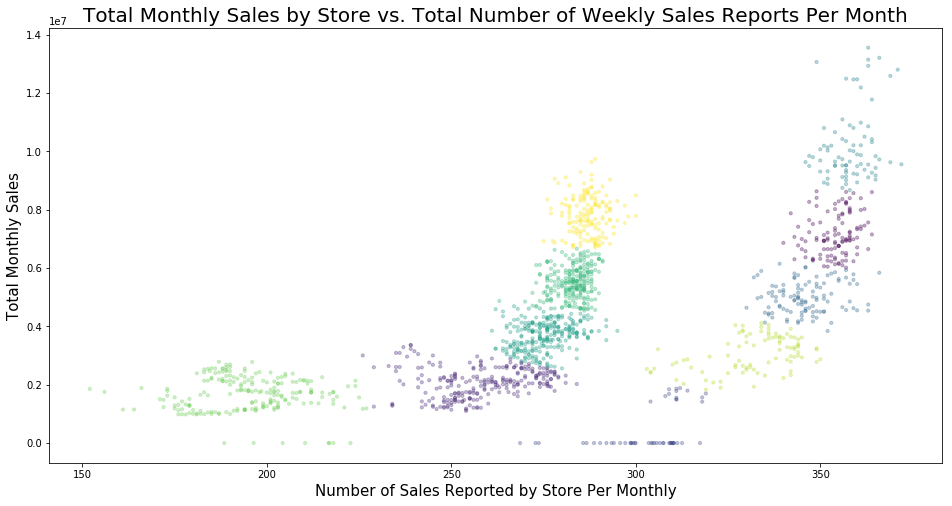

In [695]:
#for i in range(5, 20):
a = 'shift_monthly_sales_count'
b = 'previous_month_sales'

features_1 =[a, b]

scaler = StandardScaler()

algo = 'elkan'  #### alterable 

num = 10 ### alterable 

init = 'random'

X_cluster_1 = final_month[features_1]

X_scaled_1 = scaler.fit_transform(X_cluster_1)

eps = .2 ### for dbscan 
min_samples = 40 ### for dbscan

km_1 = KMeans(n_clusters=num, random_state=1, algorithm = algo, init = init, precompute_distances = True)
#km_1 = DBSCAN( eps = eps, min_samples=min_samples, algorithm = 'ball_tree').fit(X_scaled_1)

km_1.fit(X_scaled_1)

cluster_1 = km_1.labels_

cluster_1_dums = pd.get_dummies(cluster_1)

plt.figure(figsize=(16,8))
plot = plt.scatter(final_month[a], final_month[b], alpha=.3, s = 10, c = cluster_1)
plt.xlabel('Number of Sales Reported by Store Per Monthly', size = 15)
plt.ylabel('Total Monthly Sales', size = 15)
plt.title('Total Monthly Sales by Store vs. Total Number of Weekly Sales Reports Per Month', size = 20)


### Defines function for unsupervised machine learning method
#### alterable variables:
#### 1) algorithm
#### 2) number of clusters 
#### 3) data selection initiation
#### 4) Features (intuitive, looking for features with continuous values...excludes features such as store number

In [101]:
 def unsupervised(data, first, second):
    
    a = first
    b = second
    
    features_1 =[a, b]
    
    scaler = StandardScaler()  ### standardizes all data for consumption
    
    algo = 'elkan'
    num = 20
    init = 'random'
    
    X_cluster_1 = data[features_1]
    X_scaled_1 = scaler.fit_transform(X_cluster_1)
    #km_1 = DBSCAN( eps = eps, min_samples=min_samples, algorithm = 'ball_tree').fit(X_scaled_1)
    km_1 = KMeans(n_clusters=num, random_state=1, algorithm = algo, init = init, precompute_distances = True)
    
    km_1.fit(X_scaled_1)
    cluster_1 = km_1.labels_
    cluster_1_dums = pd.get_dummies(cluster_1, prefix = 'featureset_1')
    cluster_1_dums.reset_index(drop=True, inplace=True)
    
    data.reset_index(drop=True, inplace=True)   
    a_new = pd.concat([data,cluster_1_dums], axis = 1)

    X_train = a_new
    
    return(X_train)

## Global Variables

In [676]:
#### final_month is for monthly 
#### final_quarter_df is for Q4 2012
#### final_quarter is for Q1 2013


offset = 0 ### offset utilized in backtesting
model = 'quarterly' ### monthly or quarterly predictions
backtesting = 8 ### recommended 7 or lower for quarterly and 20 - 15 for monthly.....allows for enough training data
data = final_quarter

### unsupervised variables monthly for 11/2012, quarterly for quarter predictions
first_var = 'shift_quarterly_sales_count'
second_var = 'previous_quarter_sales'

### Assigns unsupervised learning features and new features for analysis 
new_df = unsupervised(data, first_var, second_var)


### monthly count for 11/2012 and quarterly for quarter predictions
over_mean_1 = new_df.shift_quarterly_sales_count
over_mean_2 = new_df.shift_quarterly_sales_count.mean()
new_df['over_count_mean'] = np.where(over_mean_1 >= over_mean_2, 1, 0) 


## Supervised Machine Learning Analysis and Predictions
### Multiple alterable items within Random Forest Regressor model
#### Dynamic, can be run for both monthly and quarterly predictions


1


Text(0.5, -0.1, 'Total Value ($) of Error Between Actual and Predicted: [-5131572.425625019]')

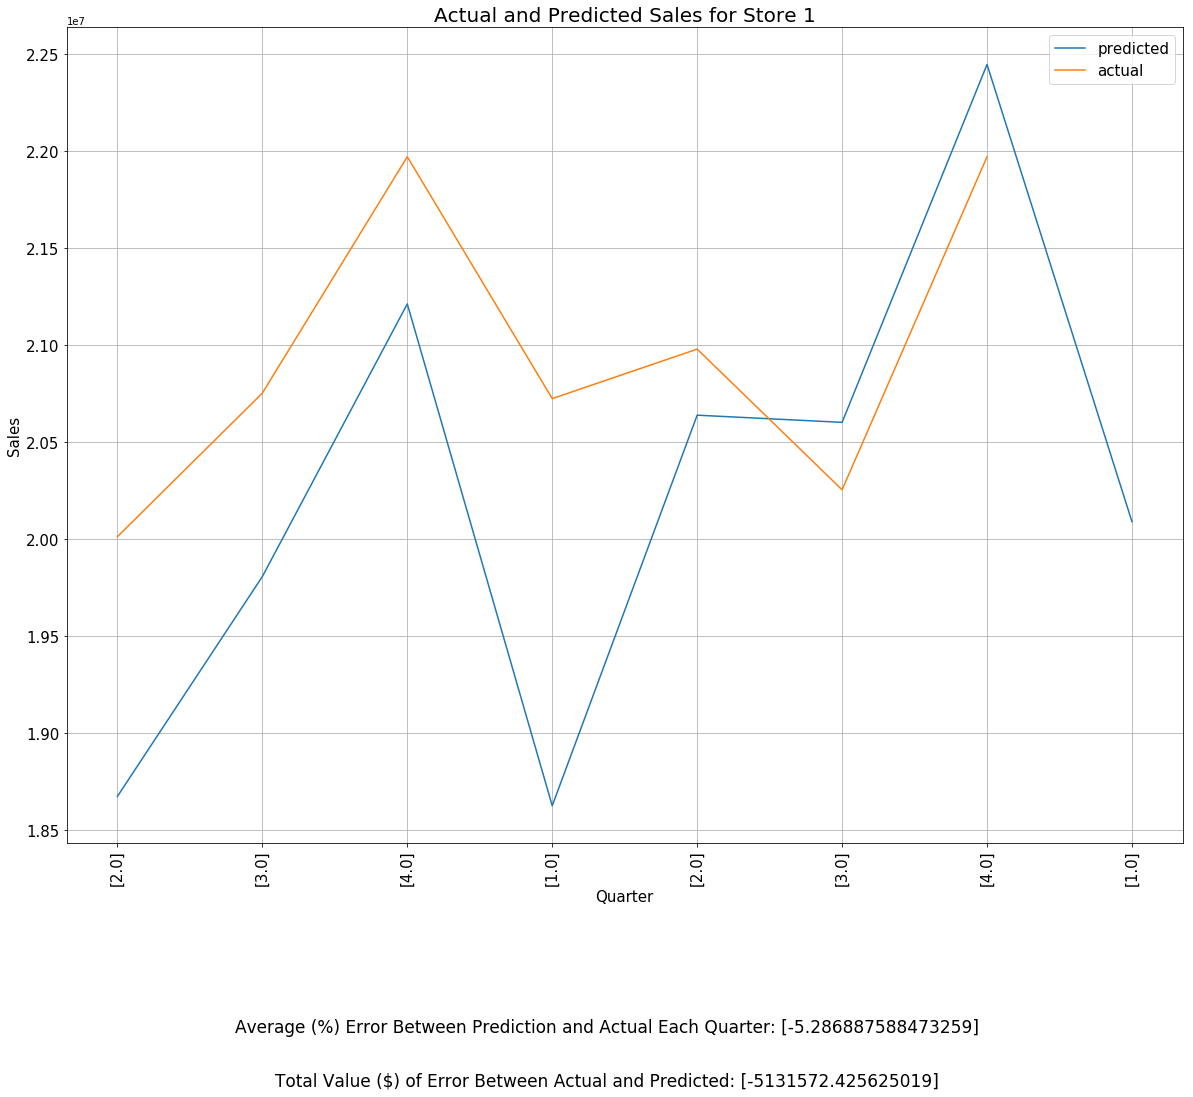

In [693]:



#### Assigns variables for appending values in backtesting 
avg = []
summed = []
predicted = []
actual = []
months = []
test_append = []
store_value = []

#new_df.store.unique()
#range(1,2,1) ### use for graphing
store = 1
for store in range(1,2,1) :
    
    
    print(store)
    new_df = new_df.sort_index(ascending = False)
    new_df_1 = new_df[new_df.store == store]


    if model == 'monthly':
        X = new_df_1.drop(['total_monthly_sales', 
                     'monthly_sales_count',
                     'monthly_rank'], axis = 1)

        y = new_df_1['total_monthly_sales']
        
    elif model == 'quarterly':
        X = new_df_1.drop(['total_quarterly_sales', 
                     'quarterly_sales_count',
                     'quarter_rank'], axis = 1)

        y = new_df_1['total_quarterly_sales']


    for i in range(offset, backtesting, 1):

        start_test = i

        end_test = start_test+1

        start_train = (end_test)     

        end_train = (start_train) + (len(X))

        #################################################

        X_train = X[start_train:end_train]

        X_test = X[start_test:end_test]

        y_train = y[start_train:end_train]

        y_test = y[start_test:end_test]

        RF = RFR(n_estimators = 8)

        y_train = y_train.values.ravel()

        y_test = y_test.values.ravel()

        RF.fit(X_train, y_train)

        y_pred = RF.predict(X_test)

        error = ((y_pred - y_test)/y_test)*100
        diff = (y_pred - y_test)
        
        
        if model == 'monthly':
       
            month = list(X_test.month)
            months.append(month)
            avg.append(error)
            summed.append(diff)
            predicted.append(y_pred)
            actual.append(y_test)
            
            metrics = list(zip(predicted, avg, summed))
        
        elif model == 'quarterly':

            quarter = list(X_test.quarter)
            months.append(quarter)
            predicted.append(y_pred)
            actual.append(y_test)  
            avg.append(error)
            summed.append(diff)
       
        metrics = list(zip(predicted, avg, summed))
        
    nate = pd.DataFrame(metrics, columns = ['prediction', 'average_error', 'summed_error'])
    #print(nate)
    nate_mean= list(nate.average_error[3:len(nate)].mean())
    nate_summed= list(nate.summed_error[2:len(nate)].sum()) 
    final = nate.prediction[0]
    test_append.append(final)
    store_value.append(store)  

    
### Null these values for graph of predictions                       #########
    #predicted =[]
    #avg =[]
   #summed = []                                                     #########
    
    
##################### Graphing Variables ##########################
predicted.reverse()
actual.reverse()
months.reverse()

total = list(zip(predicted, actual, months))
final_data = pd.DataFrame(total,columns=['predicted', 'actual', 'month'])

plt.figure(figsize=(20,15))
plt.plot(final_data.predicted)
plt.plot(final_data.actual[0:len(final_data)-1])
plt.xticks(np.arange(len(final_data.month)), final_data.month, rotation = 90, size = 15)
plt.yticks(size = 15)
plt.grid()
plt.legend(loc='best',prop={'size': 15})
plt.title(str('Actual and Predicted Sales for Store '+ str(store)), size = 20)
plt.xlabel('Quarter', size = 15)
plt.ylabel('Sales', size = 15)
txt=str('Average (%) Error Between Prediction and Actual Each Quarter: '+ str(nate_mean))
txt_2=str('Total Value ($) of Error Between Actual and Predicted: '+ str(nate_summed))

plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=17)
plt.figtext(0.5, -0.1, txt_2, wrap=True, horizontalalignment='center', fontsize=17)

### Creates Dataframes for prediction outputs

In [690]:
store_values = pd.DataFrame(store_value, columns = ['store'])
test_appended = pd.DataFrame(test_append, columns = ['prediction'])

test_final = pd.concat([store_values, test_appended], axis = 1).sort_values('store', ascending = True)

In [692]:
test_final.to_excel('Q1_2013_predictions.xlsx')

                          Importance %
Features                              
month                         0.524556
previous_month                0.199596
shift_monthly_sales_count     0.136236
featureset_1_6               0.0834631
quarter                      0.0200396
previous_months_rank         0.0100666
previous_quarter            0.00985662
featureset_1_8              0.00814972
featureset_1_12             0.00551238
previous_month_sales        0.00235216
featureset_1_5              0.00010852
number_depts               3.47355e-05
featureset_1_3             2.86391e-05
featureset_1_1                       0
year                                 0
featureset_1_19                      0
featureset_1_18                      0
featureset_1_17                      0
featureset_1_16                      0
featureset_1_15                      0
featureset_1_14                      0
featureset_1_13                      0
featureset_1_11                      0
featureset_1_2           

Text(0.5, 1.0, 'Feature Imprtance for Oil price prediction(higher or lower every 2 hours)')

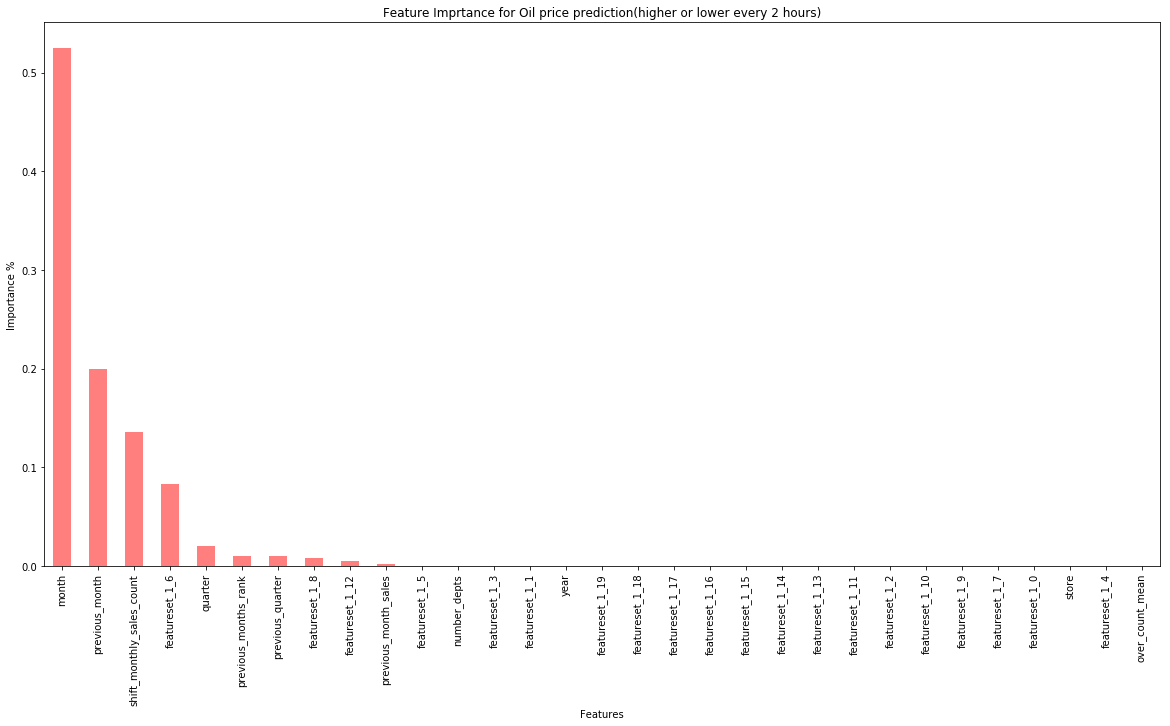

In [553]:
features = X_train.columns

feature_imp = (RF.feature_importances_)

importances = pd.DataFrame([features,feature_imp])

final_test = importances.transpose()

final_test.columns = ['Features', 'Importance %']

final_test = final_test.sort_values(by = 'Importance %', ascending = False)

final_test = final_test.set_index('Features')

print(final_test)

graph = final_test['Importance %'].plot(kind = 'bar', color = 'r', alpha = .5,figsize=(20,10),label = 'Actual Strategy Outcomes (from test data)')
graph.set_ylabel('Importance %')

graph.set_title('Feature Imprtance for Oil price prediction(higher or lower every 2 hours)')

### Checks for which months for each store are missing values

#### Verifies that all stores are mission 1/2010 data

In [137]:
for a in total_sales.store.unique():
    print('###########')
    for i in range(1, 13, 1):
        tester = len(total_sales[(total_sales.store == a) &(total_sales.month == i)])
        if tester <3:
            print('store:', a, 'Month missing data:', i)
        

###########
store: 1 Month missing data: 1
store: 1 Month missing data: 11
store: 1 Month missing data: 12
###########
store: 2 Month missing data: 1
store: 2 Month missing data: 11
store: 2 Month missing data: 12
###########
store: 3 Month missing data: 1
store: 3 Month missing data: 11
store: 3 Month missing data: 12
###########
store: 4 Month missing data: 1
store: 4 Month missing data: 11
store: 4 Month missing data: 12
###########
store: 5 Month missing data: 1
store: 5 Month missing data: 11
store: 5 Month missing data: 12
###########
store: 6 Month missing data: 1
store: 6 Month missing data: 11
store: 6 Month missing data: 12
###########
store: 7 Month missing data: 1
store: 7 Month missing data: 11
store: 7 Month missing data: 12
###########
store: 8 Month missing data: 1
store: 8 Month missing data: 11
store: 8 Month missing data: 12
###########
store: 9 Month missing data: 1
store: 9 Month missing data: 11
store: 9 Month missing data: 12
###########
store: 10 Month missing d

In [581]:
the_list =[]
day_list =[]

for i in range(152, 372):

    list_count = len(day_counts[day_counts.monthly_sales_count <= i ])/len(day_counts)
    the_list.append(list_count)
    day_list.append(i)
    
the_list = pd.DataFrame(the_list)

day_list = pd.DataFrame(day_list)

final_list = pd.concat([the_list, day_list], axis = 1)

final_list.columns = ['percent_below', 'number_weekly_sales_reported']

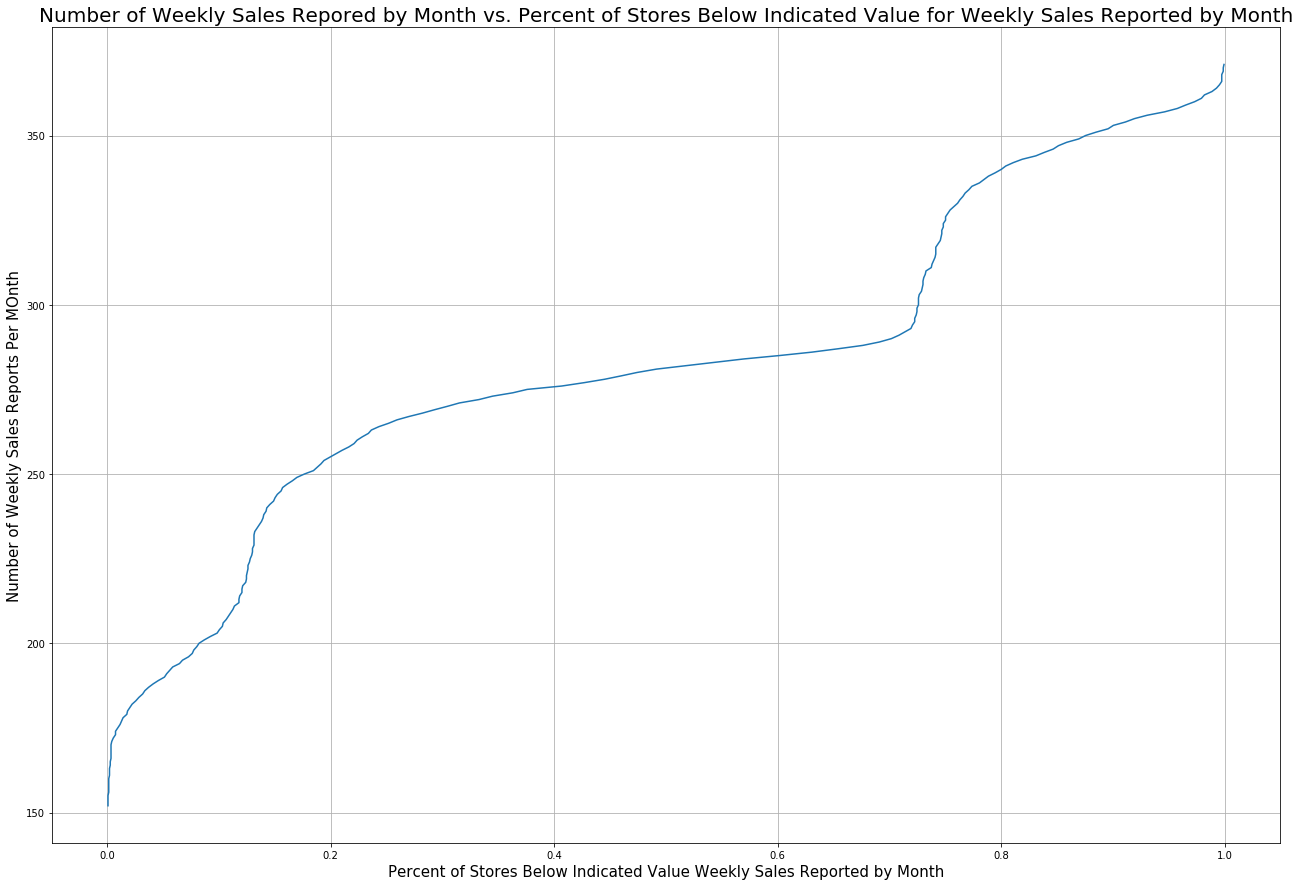

In [595]:
plt.figure(figsize=(22,15))
plt.plot(final_list.percent_below, final_list.number_weekly_sales_reported)
plt.xlabel('Percent of Stores Below Indicated Value Weekly Sales Reported by Month', size = 15)
plt.ylabel('Number of Weekly Sales Reports Per MOnth', size = 15)
plt.title('Number of Weekly Sales Repored by Month vs. Percent of Stores Below Indicated Value for Weekly Sales Reported by Month', size = 20)


plt.grid()
